In [1]:
import cupy as cp
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
from tqdm import tqdm

class SuperPixels:
    def __init__(self, h, w, r=0, g=0, b=0):
        self.update(h, w, r, g, b)

    def update(self, h, w, r, g, b):
        self.h = h
        self.w = w
        self.r = r
        self.g = g
        self.b = b

In [2]:
def initial_cluster_center(S, img, img_h, img_w, k):
    clusters = []
    for _ in range(k):
        h = np.random.randint(0, img_h)
        w = np.random.randint(0, img_w)
        clusters.append(SuperPixels(h, w, img[h, w, 0], img[h, w, 1], img[h, w, 2]))
    return np.array(clusters)


In [3]:
def assign_pixels_to_cluster(clusters, S, img_rgb, img_h, img_w, tag, dis, m):
    for c in (range(len(clusters))):
        # print(c)
        current_cluster = clusters[c]
        h_center, w_center = int(current_cluster.h), int(current_cluster.w)
        r_center, g_center, b_center = current_cluster.r, current_cluster.g, current_cluster.b

        for h in range(max(0, h_center - 2*S), min(img_h, h_center + 2*S)):
            for w in range(max(0, w_center - 2*S), min(img_w, w_center + 2*S)):
                r, g, b = img_rgb[h, w]
                Dc = math.sqrt((r - r_center) ** 2 + (g - g_center) ** 2 + (b - b_center) ** 2)
                Ds = math.sqrt((h - h_center) ** 2 + (w - w_center) ** 2)
                D = math.sqrt((Dc / m) ** 2 + (Ds / S) ** 2)

                if D < dis[h, w]:
                    dis[h, w] = D
                    tag[(h, w)] = c

def update_cluster_mean(clusters, img, tag):
    for c in range(len(clusters)):
        assigned_pixels = []
        for p, cluster in tag.items():
            if cluster == c:
                assigned_pixels.append(p)
        # assigned_pixels = [p for p, cluster in tag.items() if cluster == c]
        if len(assigned_pixels) == 0:
            continue

        pixels_arr = np.array(assigned_pixels)
        mean_h, mean_w = np.mean(pixels_arr, axis=0).astype(int)

        if 0 <= mean_h < img.shape[0] and 0 <= mean_w < img.shape[1]:
            r, g, b = img[mean_h, mean_w]
            clusters[c].h, clusters[c].w = mean_h, mean_w
            clusters[c].r, clusters[c].g, clusters[c].b = r, g, b

def avg_color_cluster(img, clusters, tag):
    output_image = np.copy(img)

    for p, cluster in tag.items():
        
        output_image[p[0], p[1]] = (clusters[cluster].r, clusters[cluster].g, clusters[cluster].b)

    for c in range(clusters.shape[0]):
        output_image[int(clusters[c].h), int(clusters[c].w)] = (0, 0, 0)

    return output_image

In [4]:
def slic(S, img, img_h, img_w, tag, dis, k, m):
    clusters = initial_cluster_center(S, img, img_h, img_w, k)
    for i in range(5):
        print(i)
        assign_pixels_to_cluster(clusters, S, img, img_h, img_w, tag, dis, m)
        update_cluster_mean(clusters, img, tag)
    return avg_color_cluster(img, clusters, tag)

In [5]:
def slic_each_iteration(S, img, img_h, img_w, tag, dis, k, m):
    clusters = initial_cluster_center(S, img, img_h, img_w, k)

    for i in range(5): 
        assign_pixels_to_cluster(clusters, S, img, img_h, img_w, tag, dis, m)
        update_cluster_mean(clusters, img, tag)

        iter_image = avg_color_cluster(img, clusters, tag)
        iter_image_rgb = np.clip(iter_image, 0, 255).astype(np.uint8)

        plt.imshow(iter_image_rgb)
        plt.axis("off")
        plt.title(f"Iteration {i + 1}")

        plt.savefig(f"iteration_rgb{i+1}.jpg")

        plt.draw()
        plt.pause(0.5)

    return avg_color_cluster(img, clusters, tag)

In [6]:
def show_the_image(k, m, param):
    image = cv2.imread("frame_0000.jpg")
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    image_rgb = image_rgb.astype(np.int32)

    height, width, _ = image_rgb.shape
    Number_of_pixels = height * width

    S = int(math.sqrt(Number_of_pixels / k))

    tag = {}
    dis = cp.full((height, width), cp.inf)
    if param == 1:
        output_image = slic(S, image_rgb, height, width, tag, dis, k, 20)

        output_image_uint8 = np.clip(output_image, 0, 255).astype(np.uint8)

        plt.imshow(output_image_uint8)
        plt.axis("off")  # Hide axes
        plt.savefig("final_output_rbg.jpg")  # Save image
        plt.show()
    elif param == 2:
        output_image = slic_each_iteration(S, image_rgb, height, width, tag, dis, k, m)



0
1
2
3
4


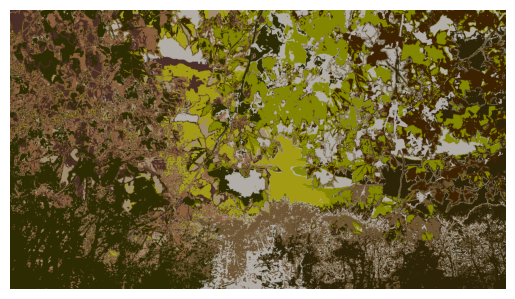

In [7]:
show_the_image(10, 20, 1)

0
1
2
3
4


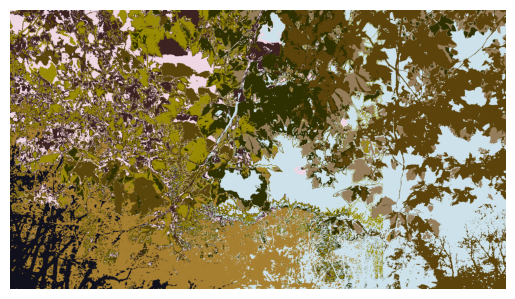

In [8]:
show_the_image(10, 40, 1)